In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt


(63, 2)


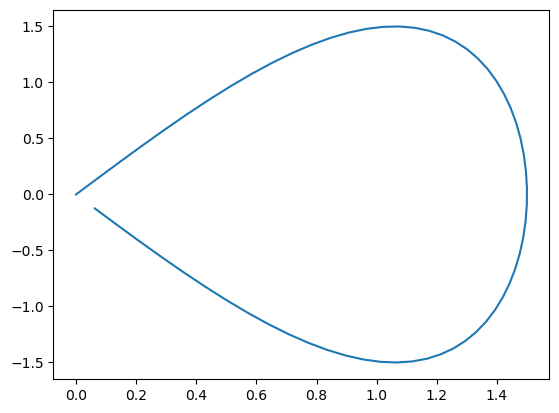

In [2]:
dt = 0.5
tend = 10*np.pi
ts = np.arange(0,tend,step=dt)

x_r =  1.5*np.sin(0.1*ts)
y_r =  1.5*np.sin(0.2*ts)


xdot_r = 0.15*np.cos(0.1*ts)
ydot_r = 0.30*np.cos(0.2*ts)

xddot_r = -0.015*np.sin(0.1*ts)
yddot_r = -0.060*np.sin(0.2*ts)

theta = np.zeros_like(xdot_r)
omega = np.zeros_like(xddot_r)
vs = np.zeros_like(x_r)
for i in range(len(theta)):
    theta[i] = np.arctan2(ydot_r[i],xdot_r[i])
    omega[i] = 1.0/(1.0 + (ydot_r[i]/xdot_r[i])**2)*(-0.4*np.cos(0.1*ts[i])*np.sin(0.2*ts[i]) + 0.2*np.sin(0.1*ts[i])*np.cos(0.2*ts[i]))/np.cos(0.1*ts[i])**2
    vs[i] = np.sqrt(xdot_r[i]**2 + ydot_r[i]**2)

plt.plot(x_r,y_r)

u = jnp.vstack((vs, omega)).T
print(u.shape)



In [3]:

from typing import Callable, Union
import jax.numpy as jnp
import equinox
import jax
import functools

v_r = vs[0]
w_r = omega[0]


def runge_kutta_integrator(dynamics, dt=0.1):
    # zero-order hold
    def integrator(x, u, t):
        dt2 = dt / 2.0
        k1 = dynamics(x, u, t)
        k2 = dynamics(x + dt2 * k1, u, t + dt2)
        k3 = dynamics(x + dt2 * k2, u, t + dt2)
        k4 = dynamics(x + dt * k3, u, t + dt)
        return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return integrator

@functools.partial(jax.jit, static_argnames=["dynamics"])
def linearize(dynamics, state, control, t):
    A, B = jax.jacobian(dynamics, [0, 1])(state, control, t)
    C = dynamics(state, control, t) - A @ state - B @ control
    return A, B, C

class Dynamics(equinox.Module):
    dynamics_func: Callable
    state_dim: int
    control_dim: int

    def __init__(self, dynamics_func, state_dim, control_dim):
        self.dynamics_func = dynamics_func
        self.state_dim = state_dim
        self.control_dim = control_dim

    def linearize(self, state0, control0, time):
        A, B, C = linearize(self.dynamics_func, state0, control0, time)
        return A @ state0 + B @ control0 + C

    def __call__(self, state, control, time=0):
        return self.dynamics_func(state, control, time)

class ControlAffineDynamics(Dynamics):
    drift_dynamics: Callable
    control_jacobian: Callable
    state_dim: int
    control_dim: int


    def __init__(self, drift_dynamics, control_jacobian, state_dim, control_dim):
        self.drift_dynamics = drift_dynamics
        self.control_jacobian = control_jacobian
        def dynamics_func(x, u, t):
            return drift_dynamics(x,t) + control_jacobian(x,t) @ u
        super().__init__(dynamics_func, state_dim, control_dim)

    def open_loop_dynamics(self, state, time=0.):
        return self.drift_dynamics(state, time)
    
class Unicycle(ControlAffineDynamics):
    state_dim: int = 3
    control_dim: int = 2

    def __init__(self):
        def drift_dynamics(state, time):
            return jnp.array([0., 0., 0.])
        def control_jacobian(state, time):
            _, _, th = state
            # v, om = control
            return jnp.array(
                [
                    [jnp.cos(th), 0.],
                    [jnp.sin(th), 0.],
                    [0., 1.]
                ]
            )

        super().__init__(drift_dynamics, control_jacobian, self.state_dim, self.control_dim)

class UnicycleError(ControlAffineDynamics):
    state_dim: int = 3
    control_dim: int = 2
    v_r: float
    w_r: float

    def __init__(self, v_r, w_r):
        self.v_r = v_r
        self.w_r = w_r
        def drift_dynamics(state, time):
            x,y,th = state
            
            return jnp.array([self.v_r*jnp.cos(th), self.v_r*jnp.sin(th), self.w_r])
        def control_jacobian(state, time):
            x, y, th = state
            # v, om = control
            return jnp.array(
                [
                    [-1.0, y],
                    [0.0, -x],
                    [0., -1.]
                ]
            )

        super().__init__(drift_dynamics, control_jacobian, self.state_dim, self.control_dim)

    def set_vr(self, vr):
        self.v_r = vr
    
    def set_wr(self, wr):
        self.w_r = wr


def get_discrete_time_dynamics(continuous_time_dynamics: Dynamics, dt: float) -> Dynamics:
    discete_dynamics = runge_kutta_integrator(continuous_time_dynamics, dt)
    return Dynamics(discete_dynamics, continuous_time_dynamics.state_dim, continuous_time_dynamics.control_dim)

# def get_linearized_dynamics(dynamics: Dynamics, state0, control0, time):
#     A, B, C = linearize(dynamics, state0, control0, time)
#     return LTIDynamics(A, B, C)
        

In [4]:

# ct_robot_dynamics = UnicycleError() # robot dynamics
# dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics

ct_robot_dynamics_abs = Unicycle()
dt_robot_dynamics_abs = get_discrete_time_dynamics(ct_robot_dynamics_abs, dt=dt)

# state_dim = dt_robot_dynamics.state_dim
# control_dim = dt_robot_dynamics.control_dim

@functools.partial(jax.jit, static_argnames=["dt_dynamics"])
def simulate_discrete_time_dynamics(dt_dynamics, state, controls, t0, dt):
    states = [state]
    t1 = t0
    for c in controls:
        state = dt_dynamics(state, c, t1)
        states.append(state)
        t1 += dt
    return jnp.stack(states)

# IC = jnp.array([0.0, 0.0, 0.0])
# IC_abs = jnp.array([0.0, 0.0, theta[0]])
# trajectory = simulate_discrete_time_dynamics(dt_robot_dynamics, IC, u, 0.0, dt)
# trajectory_abs = simulate_discrete_time_dynamics(dt_robot_dynamics_abs, IC_abs, u, 0.0, dt)




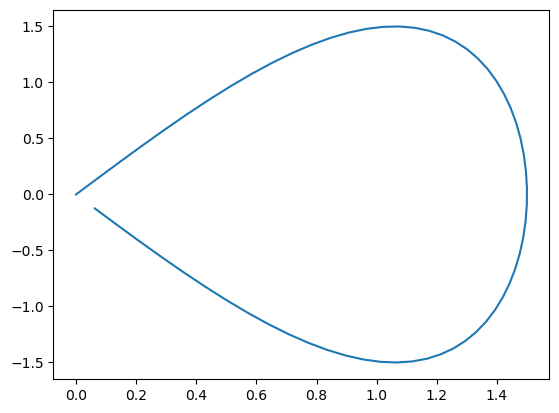

In [5]:
# xt = -trajectory[:-1,0] + x_r
# yt = -trajectory[:-1,1] + y_r
# tht = trajectory[:,2]

# xabs = trajectory_abs[:-1,0]
# yabs = trajectory_abs[:-1,1]

obstacle_location = jnp.array([1.51, .1])
obstacle_radius = 0.2
circle = plt.Circle(obstacle_location,obstacle_radius)
fig, ax = plt.subplots()
# plt.plot(xt,yt)
plt.plot(x_r,y_r)
# plt.plot(xabs,yabs)
# ax.add_patch(circle)

In [6]:
@jax.jit
def h(state, obstacle, radius):
    x, y, th = state
    x_o, y_o = obstacle
    result = (x-x_o)**2 + (y-y_o)**2 - radius**2
    return result

alpha, beta, zeta = 0.5, 0.5, 0.5
alpha = 0.5
beta = 0.5
zeta = .5

# @jax.jit
# def V(X,t):
#     x,y,th = X
#     # x_r, y_r, th_r = X_r
#     return alpha*(x-1.5*jnp.sin(0.1*t))**2 + beta*(y-1.5*jnp.sin(0.2*t))**2 + zeta*(th-2*jnp.cos(0.2*t)/jnp.cos(0.1*t))**2


@jax.jit
def V(X,t):
    x,y,th = X
    # x_r, y_r, th_r = X_r
    return alpha*(x)**2 + beta*(y)**2 + zeta*(th)**2

# c1 = 1.0
# c2 = 1.0
# c3 = 1.0

# def V(X,t):
#     x,y, th, = X
#     z_e = 1-jnp.cos(th/2)
#     return c2/2.0*(jnp.sqrt(1+x**2+y**2)-1) + 4*z_e


In [7]:
import cvxpy as cp

a = 0.001
lda = 1.0

c1 = 1
c2 = 1
c3 = 1

ct_robot_dynamics = UnicycleError(v_r=v_r, w_r=w_r) # robot dynamics
# print(ct_robot_dynamics.v_r)
dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics



v = u[0]
w = u[1]
Xs = [jnp.array([0.0, -0.5, -theta[0]])]
Xs_abs = [(jnp.array([x_r[0], y_r[0], theta[0]])-Xs[0])]
controls = []
gamma = cp.Variable()
for i in range(0,len(ts)):
    
    X = Xs[-1]
    x, y, th = X

    t = ts[i]
    x_ref = x_r[i]
    y_ref = y_r[i]
    th_ref = theta[i]
    X_abs = jnp.array([x_ref, y_ref, th_ref]) - X
    v_r = vs[i]
    w_r = omega[i]
    vr=1.0

    
    ct_robot_dynamics = UnicycleError(v_r=v_r, w_r=w_r) # robot dynamics
    dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics
    # ct_robot_dynamics.v_r = v_r
    # ct_robot_dynamics.w_r = w_r

    u_ref = jnp.array([v_r, w_r])
    delVT = jnp.array([[x, y, th]])
    G = jnp.array([[-1., y],
                   [0., -x],
                   [0., -1.]])
    
    f = jnp.array([[v_r*jnp.cos(th)],
                   [v_r*jnp.sin(th)],
                   [w_r]])

    
    # constraints = [delVT@f + delVT@G@u <= - a*V(X,t) + gamma] # constraint for basic lyapunov func
    # z_e = 1-jnp.cos(th/2)
    # constraints = [c1*c2*x**2/(1+x**2+y**2) - 2*c3*(1-(1-z_e)**2) <= -a*V(X,t) + gamma]
    # prob = cp.Problem(obj, constraints)
    # prob.solve()
    # control = [jnp.array(u.value)]
    added_control = jnp.array([c1*x/jnp.sqrt(x**2+y**2+1), c2*v_r*(y*jnp.cos(th/2)-x*jnp.sin(th/2)/jnp.sqrt(1+x**2+y**2))+c3*jnp.sin(th/2)])
    control = u_ref+added_control
    u = cp.Variable(2)
    v = u[0]
    w = u[1]
    h_curr = h(X_abs, obstacle_location, obstacle_radius)
    h_dot_curr = (X_abs[0]-obstacle_location[0])*v*jnp.cos(X_abs[2]) + (X_abs[1]-obstacle_location[1])*v*jnp.sin(X_abs[2])
    h_ddot_curr = v**2 - (X_abs[0]-obstacle_location[0])*w*jnp.sin(X_abs[2]) + (X_abs[1]-obstacle_location[1])*w*jnp.cos(X_abs[2])
    obj = cp.Minimize((1/2*cp.norm((u-control))**2) + lda*gamma**2)
    constraints = [h_dot_curr >= -alpha*h_curr]
    prob = cp.Problem(obj, constraints)
    prob.solve()
    control = u.value
    controls.append(control)


    # control = u_ref.reshape((1,2))
    # print(X)
    # print(control)
    # print(t)
    # print(dt)
    # print(dt_robot_dynamics)
    New_X_rel = simulate_discrete_time_dynamics(dt_robot_dynamics, X, [control], t, dt)
    New_X_abs = simulate_discrete_time_dynamics(dt_robot_dynamics_abs, X_abs, [control], t, dt)
    # print(New_X_abs)
    # print(u_ref)
    Xs_abs.append(New_X_abs[-1])
    Xs.append(New_X_rel[-1])




(64, 3)


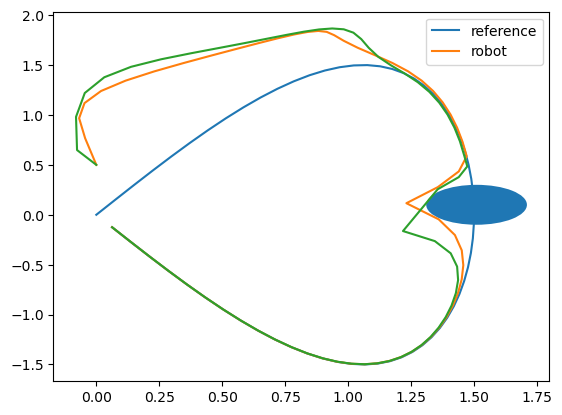

In [8]:

Xs = np.array(Xs)
xt = -Xs[:-1,0] + x_r
yt = -Xs[:-1,1] + y_r
tht = -Xs[:-1,2] + theta
Xs_abs = np.array(Xs_abs)
x_abs = Xs_abs[:-1, 0]
y_abs = Xs_abs[:-1, 1]

error = jnp.sqrt(Xs[:-1,0]**2 + Xs[:-1,1]**2)

fig1, ax1 = plt.subplots()

plt.plot(x_r,y_r, label='reference')
plt.plot(xt,yt,label='robot')
plt.plot(x_abs,y_abs)
ax1.add_patch(circle)
plt.legend()

# plt.plot(ts,error)
print(Xs.shape)

(63, 2)
(63,)


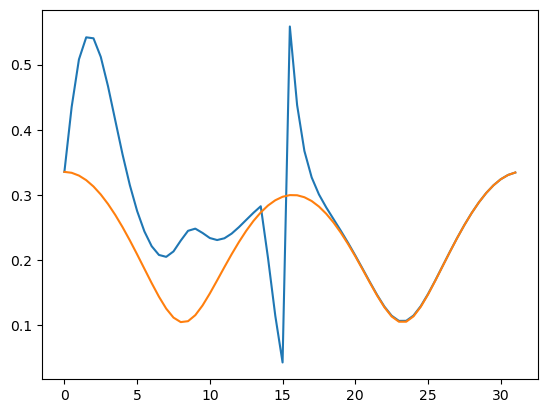

In [9]:
print(np.array(controls).shape)
v_act = np.array(controls)[:,0]
w_act = np.array(controls)[:,1]
print(v_act.shape)

plt.plot(ts,v_act)
plt.plot(ts,vs)


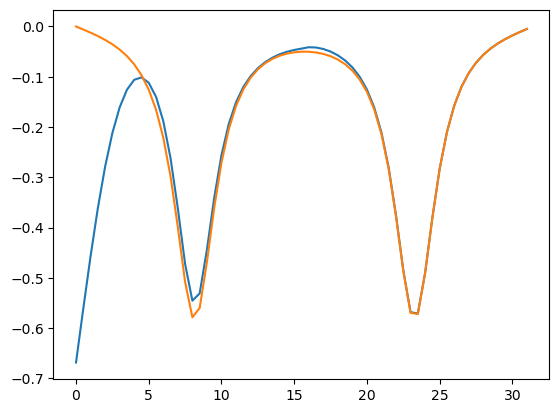

In [10]:
plt.plot(ts,w_act)
plt.plot(ts,omega)

In [11]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

import cvxpy as cp

from map import update_plot
from env_setup import environment_gen

%load_ext ipympl
%matplotlib widget

The ipympl module is not an IPython extension.


In [12]:
obst = environment_gen(num_obstacles=15,obst_scale=0.5,obst_var=0.2,map_size=4,step_size=1,seed=71)

num_time_steps = ts.shape[0]

Seed Set


In [13]:
a = 0.001
lda = 1.0

c1 = 1
c2 = 1
c3 = 1

ct_robot_dynamics = UnicycleError(v_r=v_r, w_r=w_r) # robot dynamics
# print(ct_robot_dynamics.v_r)
dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics



v = u[0]
w = u[1]
Xs = [jnp.array([0.0, -0.5, -theta[0]])]
Xs_abs = [(jnp.array([x_r[0], y_r[0], theta[0]])-Xs[0])]
controls = []
gamma = cp.Variable()
for i in range(0,len(ts)):
    
    X = Xs[-1]
    x, y, th = X

    t = ts[i]
    x_ref = x_r[i]
    y_ref = y_r[i]
    th_ref = theta[i]
    X_abs = jnp.array([x_ref, y_ref, th_ref]) - X
    v_r = vs[i]
    w_r = omega[i]
    vr=1.0

    
    ct_robot_dynamics = UnicycleError(v_r=v_r, w_r=w_r) # robot dynamics
    dt_robot_dynamics = get_discrete_time_dynamics(ct_robot_dynamics, dt=dt) # discrete time dynamics
    # ct_robot_dynamics.v_r = v_r
    # ct_robot_dynamics.w_r = w_r

    u_ref = jnp.array([v_r, w_r])
    delVT = jnp.array([[x, y, th]])
    G = jnp.array([[-1., y],
                   [0., -x],
                   [0., -1.]])
    
    f = jnp.array([[v_r*jnp.cos(th)],
                   [v_r*jnp.sin(th)],
                   [w_r]])

    
    # constraints = [delVT@f + delVT@G@u <= - a*V(X,t) + gamma] # constraint for basic lyapunov func
    # z_e = 1-jnp.cos(th/2)
    # constraints = [c1*c2*x**2/(1+x**2+y**2) - 2*c3*(1-(1-z_e)**2) <= -a*V(X,t) + gamma]
    # prob = cp.Problem(obj, constraints)
    # prob.solve()
    # control = [jnp.array(u.value)]
    added_control = jnp.array([c1*x/jnp.sqrt(x**2+y**2+1), c2*v_r*(y*jnp.cos(th/2)-x*jnp.sin(th/2)/jnp.sqrt(1+x**2+y**2))+c3*jnp.sin(th/2)])
    control = u_ref+added_control
    u = cp.Variable(2)
    v = u[0]
    w = u[1]
    h_curr = h(X_abs, obstacle_location, obstacle_radius)
    
    h_dot_curr = (X_abs[0]-obstacle_location[0])*v*jnp.cos(X_abs[2]) + (X_abs[1]-obstacle_location[1])*v*jnp.sin(X_abs[2])
    h_ddot_curr = v**2 - (X_abs[0]-obstacle_location[0])*w*jnp.sin(X_abs[2]) + (X_abs[1]-obstacle_location[1])*w*jnp.cos(X_abs[2])
    obj = cp.Minimize((1/2*cp.norm((u-control))**2) + lda*gamma**2)
    constraints = [h_dot_curr >= -alpha*h_curr]
    prob = cp.Problem(obj, constraints)
    prob.solve()
    control = u.value
    controls.append(control)


    # control = u_ref.reshape((1,2))
    # print(X)
    # print(control)
    # print(t)
    # print(dt)
    # print(dt_robot_dynamics)
    New_X_rel = simulate_discrete_time_dynamics(dt_robot_dynamics, X, [control], t, dt)
    New_X_abs = simulate_discrete_time_dynamics(dt_robot_dynamics_abs, X_abs, [control], t, dt)
    # print(New_X_abs)
    # print(u_ref)
    Xs_abs.append(New_X_abs[-1])
    Xs.append(New_X_rel[-1])


In [ ]:
Xs = np.array(Xs)

#Robot
xt = -Xs[:-1,0] + x_r 
yt = -Xs[:-1,1] + y_r
tht = -Xs[:-1,2] + theta

robot_traj = np.vstack((xt,yt,tht)).T + 2
reference_traj = np.vstack((x_r,y_r,theta)).T + 2


Xs_abs = np.array(Xs_abs)
x_abs = Xs_abs[:-1, 0]
y_abs = Xs_abs[:-1, 1]

error = jnp.sqrt(Xs[:-1,0]**2 + Xs[:-1,1]**2)

print(np.array(controls).shape)

#v_act = np.array(controls)[:,0]
#w_act = np.array(controls)[:,1]



(63, 2)


In [22]:
i_init = 0

robot_controls = np.vstack((v_act,w_act)).T
reference_controls = np.vstack((vs,omega)).T

#obstacle_radius = np.zeros_like(obst[:,1]) + np.random.rand(obst.shape[0])/2

In [40]:
def update_plot2(i, robot_trajectory, reference_trajectory, robot_controls, reference_controls, obstacles, fig, axs, acc_lims=None, vel_lims=None):
    axs[0].cla()
    axs[1].cla()
    axs[2].cla()
    #axs[3].cla()
    
    num_time_steps = reference_traj.shape[0]

    # Obst
    for obst in range(obstacles.shape[0]):
        axs[0].add_patch(plt.Circle(obstacles[obst,:2], obstacles[obst,2], color='C3', alpha=0.4))
    
    axs[0].plot(obstacles[:, 0], obstacles[:, 1],'g^', label='Obstacles')

    # Robot Pos
    axs[0].plot(robot_trajectory[:, 0], robot_trajectory[:, 1], color='C0')
    axs[0].scatter(robot_trajectory[i:i+1, 0], robot_trajectory[i:i+1, 1], s=30, color='C0')

    # Ref Pos
    axs[0].plot(reference_trajectory[:, 0], reference_trajectory[:, 1],color='C1')
    axs[0].scatter(reference_trajectory[i:i+1, 0], reference_trajectory[i:i+1, 1], s=30, color='C1')

    # Formatting
    axs[0].grid()
    axs[0].legend()
    axs[0].axis("equal")
    axs[0].set_title("Simulation")


    # v_act Plot
    axs[1].plot(robot_controls[:,0], color='C0')
    axs[1].plot(reference_controls[:,0], color='C1', linestyle='--')
    axs[1].scatter([i], robot_controls[i:i+1, 0], label="v_act", color='C0')
    if vel_lims:axs[1].hlines([vel_lims[0], vel_lims[1]], 0, num_time_steps-1, color='C2', linestyle='--')
    axs[1].set_xlim([0, num_time_steps])
    #axs[1].set_ylim([-0.5, 1])
    axs[1].set_title("States and Inputs")
    axs[1].legend()
    axs[1].grid()


    # w_act Plot
    axs[2].plot(robot_controls[:,1], color='C0')
    axs[2].plot(reference_controls[:,1], color='C1', linestyle='--')
    axs[2].scatter([i], robot_controls[i:i+1, 1], label="w_act", color='C0')
    if acc_lims: axs[2].hlines([acc_lims[0], acc_lims[1]], 0, num_time_steps-1, color='C2', linestyle='--')
    axs[2].set_xlim([0, num_time_steps])
    #axs[2].set_ylim([-1, 1])
    axs[2].legend()
    axs[2].grid()


    # theta Plot
    """axs[3].plot(robot_trajectory[:, -1], markersize=3, color='C2', label="Velocity")
    axs[3].scatter([i], robot_trajectory[i:i+1, 2], color='C2')
    #axs[3].hlines([vel_lims[0], vel_lims[1]], 0, num_time_steps-1, color='C3', linestyle='--')
    axs[3].set_xlim([0, num_time_steps])
    axs[3].set_ylim([-5, 5])
    axs[3].legend()
    axs[3].grid()"""

    

    fig.canvas.draw_idle()

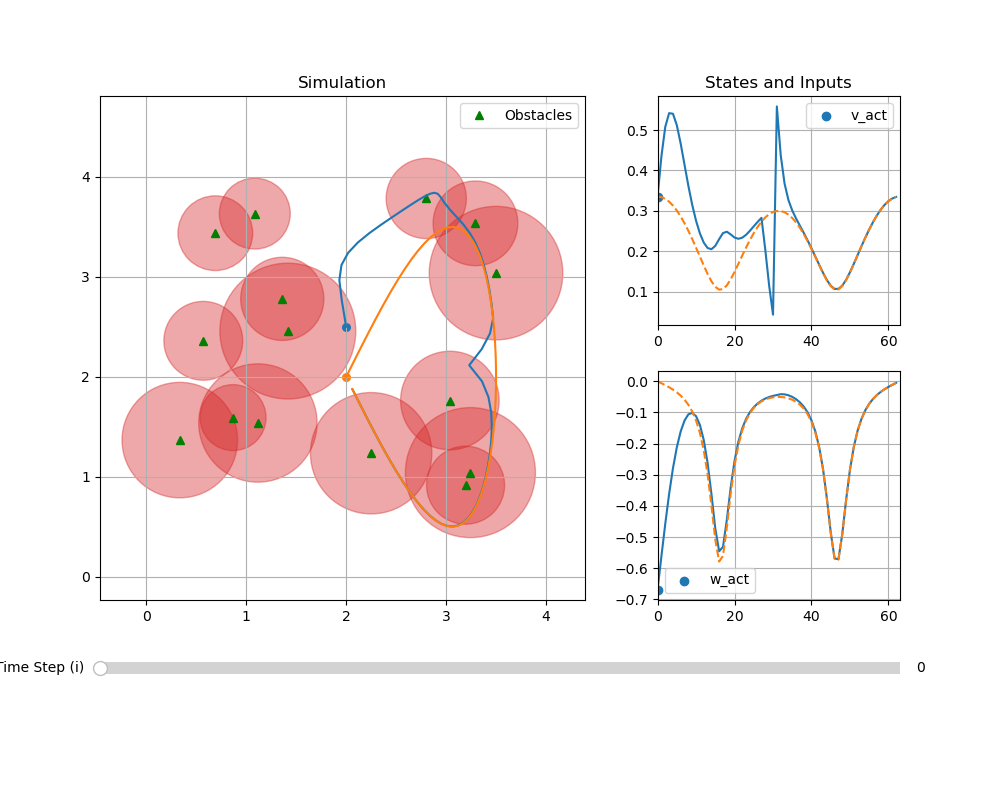

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(
    2, 2,
    width_ratios=[2, 1],   # left wide, right narrow
    height_ratios=[1, 1]   # two rows on the right
)

ax_left   = fig.add_subplot(gs[:, 0])   # spans both rows on the left
ax_right1 = fig.add_subplot(gs[0, 1])   # top-right
ax_right2 = fig.add_subplot(gs[1, 1])   # bottom-right

axs = [ax_left, ax_right1, ax_right2]   # so you can index axs[0], axs[1], axs[2]

plt.subplots_adjust(left=0.1, bottom=0.25)  # space for slider

# --- slider ---
ax_i = plt.axes([0.1, 0.15, 0.8, 0.03])

slider_i = Slider(
    ax_i,
    'Time Step (i)',
    0,
    num_time_steps - 1,
    valinit=i_init,
    valstep=1
)

def slider_callback(val):
    i_val = int(slider_i.val)
    update_plot2(
        i_val,
        robot_trajectory=robot_traj,
        reference_trajectory=reference_traj,
        robot_controls=robot_controls,
        reference_controls=reference_controls,
        obstacles=obst,
        fig=fig,
        axs=axs
    )

slider_i.on_changed(slider_callback)

update_plot2(
    i_init,
    robot_trajectory=robot_traj,
    reference_trajectory=reference_traj,
    robot_controls=robot_controls,
    reference_controls=reference_controls,
    obstacles=obst,
    fig=fig,
    axs=axs
)

plt.show()
